# NLE: Natural Language Explanations

In [1]:
%cd ..

/Users/danorel/Workspace/Education/University/NYU/Research/xeda


In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv('.env'))

True

In [3]:
import boto3
import copy
import heapq
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import pathlib
import random
import s3fs
import statistics
import traceback
import typing as t
import uuid

from collections import Counter, defaultdict
from time import time
from tqdm import tqdm

from constants import (
    AWS_ACCESS_KEY_ID,
    AWS_SECRET_ACCESS_KEY,
    AWS_S3_ENDPOINT_URL,
    AWS_S3_REGION_NAME,
    AWS_S3_BUCKET_NAME,
    AWS_S3_USE_SSL,
    GROUPS_CSV_PATH,
    OPENAI_API_KEY,
    OPENAI_EMBEDDINGS_MODEL,
    VECTOR_STORE_COLLECTION,
    VECTOR_STORE_HOST,
    VECTOR_STORE_PORT,
    UNIVERSAL_POLICY_NAME
)
from pipeline.solid.pipeline_sampler import next_node_from_request_data, next_node_from_pipeline, pipeline_to_request_data
from pipeline.resources import S3FSResource
from pipeline.solid.pipeline_annotator import annotate_pipeline
from pipeline.solid.utils.model_manager import ModelManager
from pipeline.solid.utils.pipelines.pipeline_precalculated_sets import PipelineWithPrecalculatedSets
from typings.pipeline import OperatorRequestData, Pipeline, PipelineEda4Sum
from utils.s3 import pull_keras_model
from utils.vector_store import ChromaDBVectorStore, MilvusVectorStore, SearchResult, make_document_sampler
from web.explanation.statistical import (
    length,
    number_of_sim_pipelines,
    dist_operators,
    dist_dimensions,
    familiarity,
    scattered_or_concentrated,
    payload_from_search_result
)

2024-05-08 23:10:36.499087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preparing dataset

In [22]:
REFRESH_DATASET = True

In [23]:
embedding_client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [25]:
vector_store = MilvusVectorStore(
    host=VECTOR_STORE_HOST, 
    port=VECTOR_STORE_PORT,
    collection_name=VECTOR_STORE_COLLECTION,
    refresh_data=REFRESH_DATASET,
    refresh_index=False
)

In [26]:
fs = s3fs.S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_ACCESS_KEY,
    endpoint_url=AWS_S3_ENDPOINT_URL,
    use_ssl=AWS_S3_USE_SSL,
    client_kwargs={"region_name": AWS_S3_REGION_NAME},
)

In [27]:
database_pipeline_cache = {}
database_pipeline_cache["galaxies"] = PipelineWithPrecalculatedSets(
    "sdss",
    ["galaxies"],
    discrete_categories_count=10,
    min_set_size=10,
    exploration_columns=[
        "galaxies.u",
        "galaxies.g",
        "galaxies.r",
        "galaxies.i",
        "galaxies.z",
        "galaxies.petroRad_r",
        "galaxies.redshift",
    ],
    id_column="galaxies.objID",
)

In [28]:
model_manager = ModelManager(database_pipeline_cache["galaxies"], models = {
    "set": pull_keras_model(
        s3fs=fs,
        bucket_name=AWS_S3_BUCKET_NAME,
        policy_name=UNIVERSAL_POLICY_NAME,
        model_name="set_actor",
    ),
    "operation": pull_keras_model(
        s3fs=fs,
        bucket_name=AWS_S3_BUCKET_NAME,
        policy_name=UNIVERSAL_POLICY_NAME,
        model_name="operation_actor",
    ),
    "set_op_counters": None,
})

In [29]:
groups_df = pd.read_csv(GROUPS_CSV_PATH)

### Pipeline & Embedding utils

In [30]:
def make_embedding(text):
    response = embedding_client.embeddings.create(
        input=text,
        model=OPENAI_EMBEDDINGS_MODEL
    )
    return response.data[0].embedding

In [31]:
def node_to_annotation_encoding(node):
    annotation = node["annotation"]
    node_encoding = []
    for k, v in annotation.items():
        if isinstance(v, dict):
            for key in v:
                node_encoding.append(f"{k}_{key} = {v[key]}")
        else:
            node_encoding.append(f"{k} = {v}")
    return ', '.join(node_encoding)

def annotation_subset_to_embedding(annotation_subset: t.List[str]):
    annotation_text = ';'.join(annotation_subset)
    annotation_embedding = make_embedding(annotation_text)
    return annotation_embedding

def pipeline_to_annotation_subsets(pipeline: Pipeline) -> t.List[Pipeline]:
    annotation_subsets = []
    partial_annotation = []
    for node in reversed(pipeline):
        encoded_annotation = node_to_annotation_encoding(node)
        partial_annotation.append(encoded_annotation)
        annotation_subsets.append(copy.deepcopy(partial_annotation))
    return annotation_subsets

def pipeline_to_annotation_payloads(pipeline: Pipeline):
    annotation_subsets = pipeline_to_annotation_subsets(pipeline)
    annotation_payloads = (
        [str(uuid.uuid4()) for _ in range(len(annotation_subsets))],
        [annotation_subset_to_embedding(annotation_subset) for annotation_subset in annotation_subsets]
    )
    return annotation_payloads

def pipeline_to_encoding(annotated_pipeline: PipelineEda4Sum):
    return ';'.join([node_to_annotation_encoding(node) for node in annotated_pipeline])

def pipeline_to_embedding(pipeline: PipelineEda4Sum):
    annotated_pipeline = annotate_pipeline(groups_df, pipeline)
    pipeline_encoding = pipeline_to_encoding(annotated_pipeline)
    pipeline_embedding = make_embedding(pipeline_encoding)
    return pipeline_embedding

In [32]:
def extend_pipeline_annotations(pipelines, annotated_file: str):
    annotated_filename = annotated_file.split('.')[0]
    target_type = annotated_filename.split('_')[-1]
    extended_pipeline = [
        {
            **node,
            "annotation": {
                **node['annotation'],
                'current_step': current_step,
                'target_type': target_type
            }
        }
        for current_step, node in enumerate(pipelines, 1)
    ]
    return extended_pipeline

In [33]:
def fetch_pipelines(extend_pipelines: bool = True):
    for annotated_file in fs.glob('xeda/annotated_pipelines/*.json'):
        with fs.open(annotated_file, 'r') as f:
            annotated_pipeline = json.load(f)
            if not isinstance(annotated_pipeline, list) or not len(annotated_pipeline):
                continue
            if extend_pipelines:
                annotated_pipeline = extend_pipeline_annotations(annotated_pipeline, annotated_file)
            serialized_pipeline = json.dumps(annotated_pipeline)
            if len(serialized_pipeline) > 65535:
                continue
            yield annotated_pipeline, serialized_pipeline

def insert_pipelines(vector_store, refresh: bool = True):
    if not refresh:
        print("Skipping refresh of vector storage")
        return
    for annotated_pipeline, serialized_pipeline in tqdm(fetch_pipelines()):
        (
            annotation_ids,
            annotation_embeddings
        ) = pipeline_to_annotation_payloads(annotated_pipeline)
        if len(annotation_ids) > 0:
            vector_store.insert(
                ids=annotation_ids,
                documents=[serialized_pipeline for _ in range(len(annotation_ids))],
                embeddings=annotation_embeddings,
            )

insert_pipelines(vector_store, refresh=REFRESH_DATASET)

29it [01:09,  2.39s/it]


KeyboardInterrupt: 

## Experiments

### Exploration utils

In [34]:
def explore_pipeline(partial_pipeline, database_pipeline_cache, k: int):
    # This is a stub to simulate pipeline exploration.
    # In a real scenario, this would involve applying transformations or decisions based on an RL model.
    model_manager = ModelManager(database_pipeline_cache["galaxies"], models = {
        "set": pull_keras_model(
            s3fs=fs,
            bucket_name=AWS_S3_BUCKET_NAME,
            policy_name=POLICY_NAME,
            model_name="set_actor",
        ),
        "operation": pull_keras_model(
            s3fs=fs,
            bucket_name=AWS_S3_BUCKET_NAME,
            policy_name=POLICY_NAME,
            model_name="operation_actor",
        ),
        "set_op_counters": None,
    })

    partial_request_data = pipeline_to_request_data(partial_pipeline)
    terminal_pipeline = partial_pipeline.copy()
    
    for i in range(len(partial_pipeline), len(partial_pipeline) + k):
        try:
            terminal_node, partial_request_data = next_node_from_request_data(
                partial_request_data,
                database_pipeline_cache,
                model_manager,
            )
            terminal_pipeline.append(terminal_node)
        except ValueError:
            print(f"Unexpectedly exited from pipeline generation on step {i}. Saving pipeline as it is...")
            break
    
    return terminal_pipeline

In [35]:
def one_operator(payloads, name_operator):
    operators = ['remaining_operators_by_neighbors', 'remaining_operators_by_superset', 'remaining_operators_by_distribution', 'remaining_operators_by_facet']
    operator_values = defaultdict(float)

    for operator in operators:
        operator_values[operator] += sum(p.get(operator, 0.0) for p in payloads)

    total_count = sum(operator_values.values()) + 0.000001
    percentages_length = {key: value / total_count * 100 for key, value in operator_values.items()}
    return percentages_length[name_operator]

In [36]:
def result_to_pipeline(result: SearchResult):
    try:
        return json.loads(result.get('document'))
    except:
        return {}

def result_to_id(result: SearchResult):
    try:
        return result.get('id')
    except:
        return None

def revert_pipeline(pipeline, k: int):
    return pipeline[:-k]

### Visualizations: exploration attributes distributions

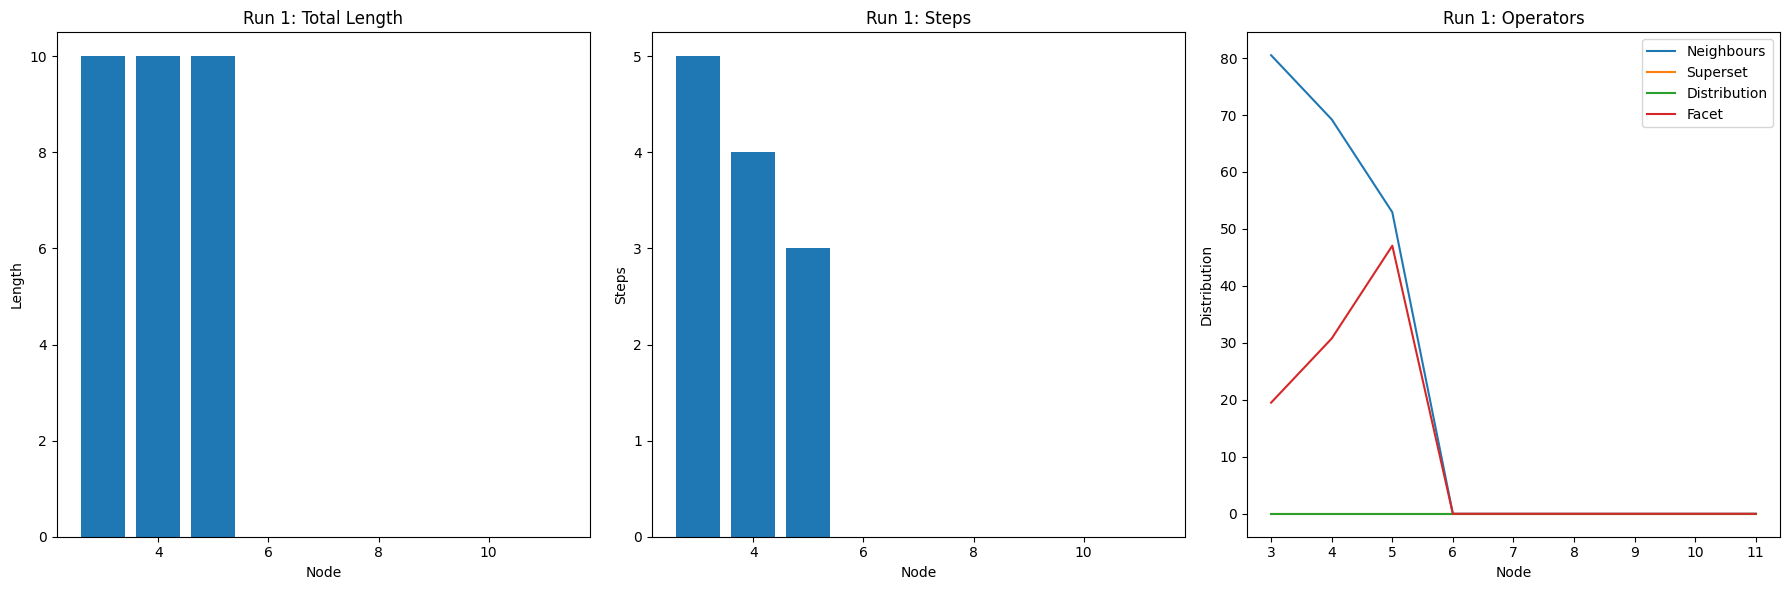

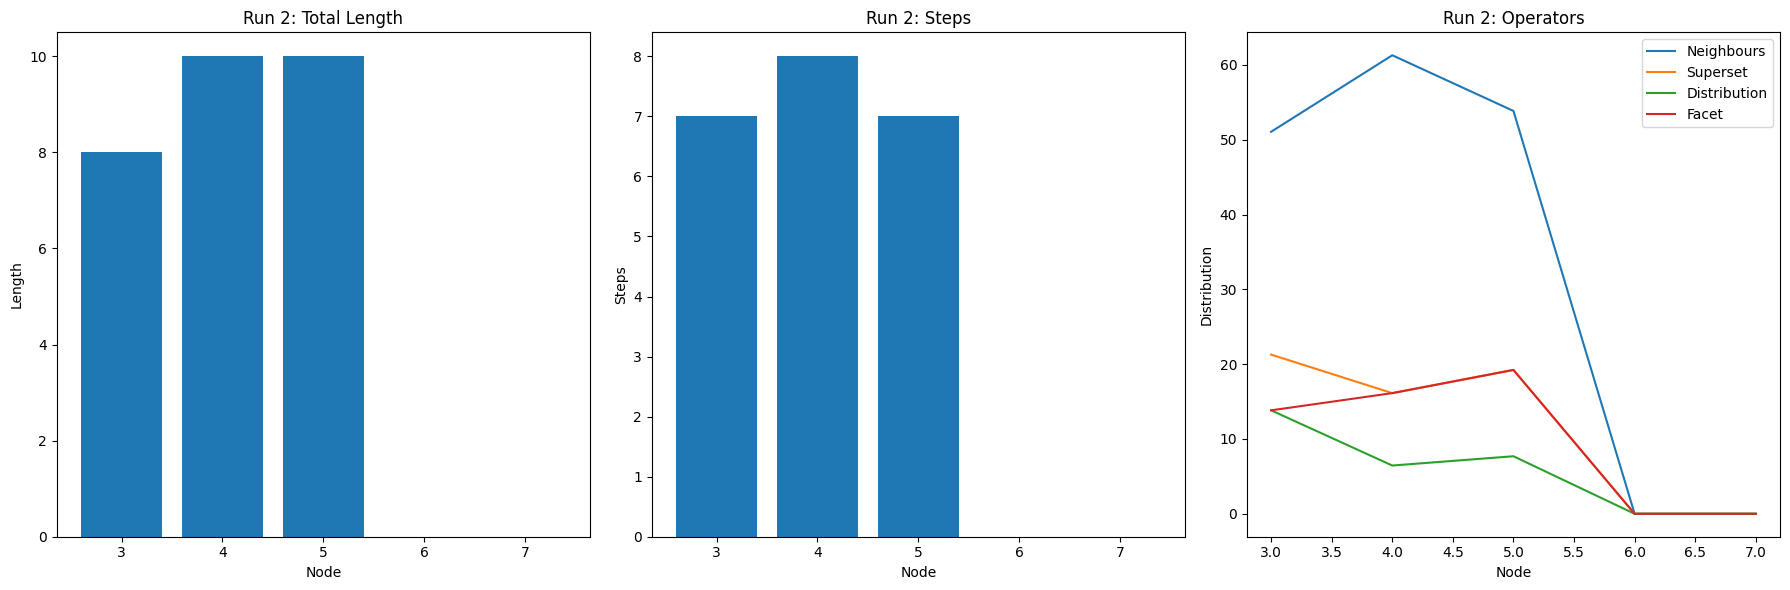

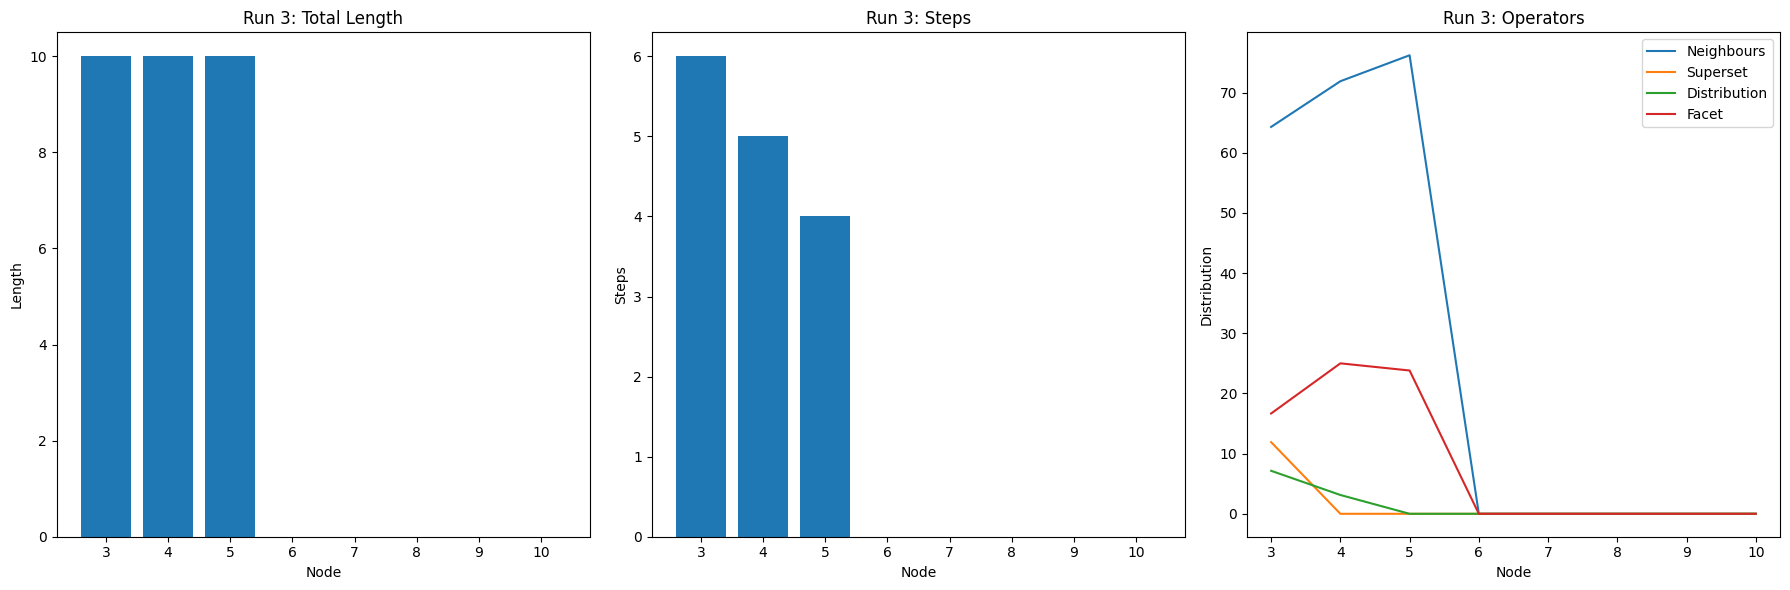

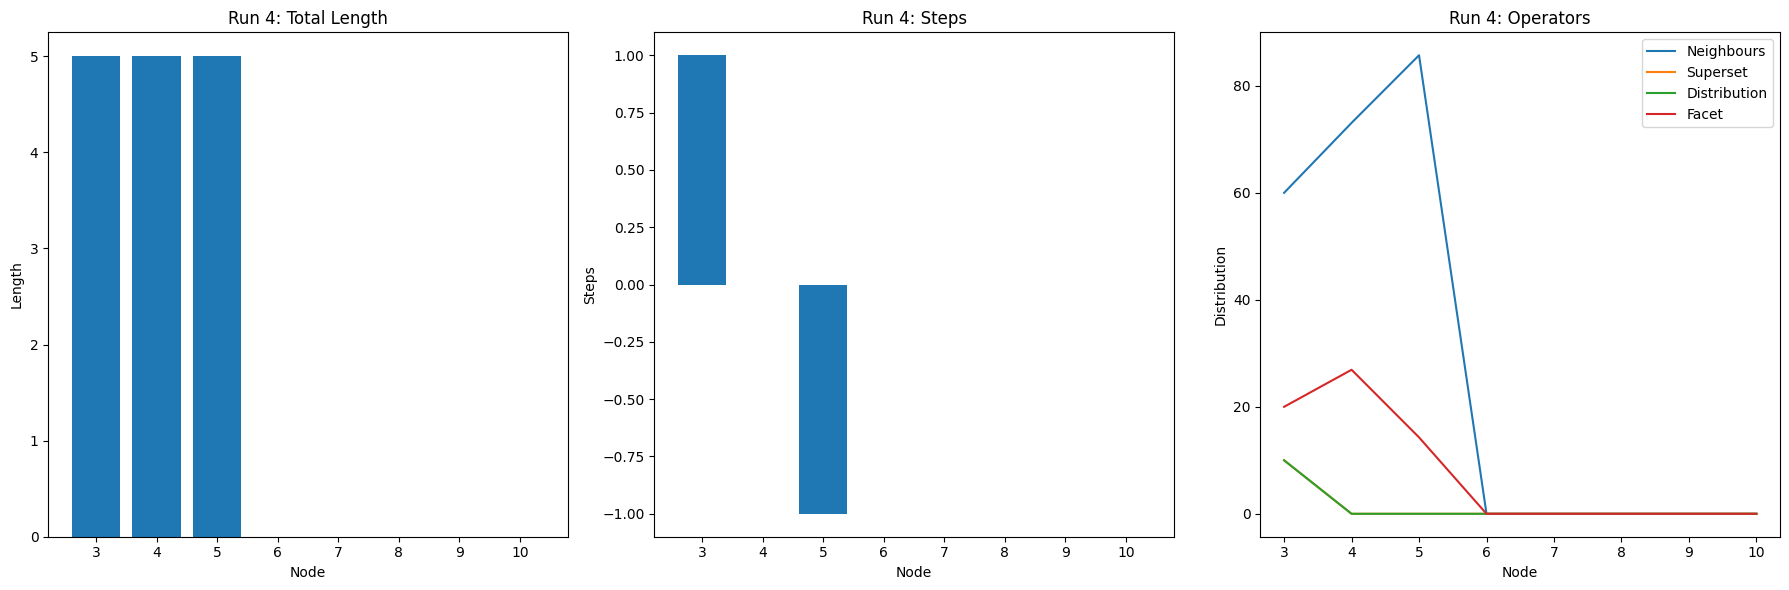

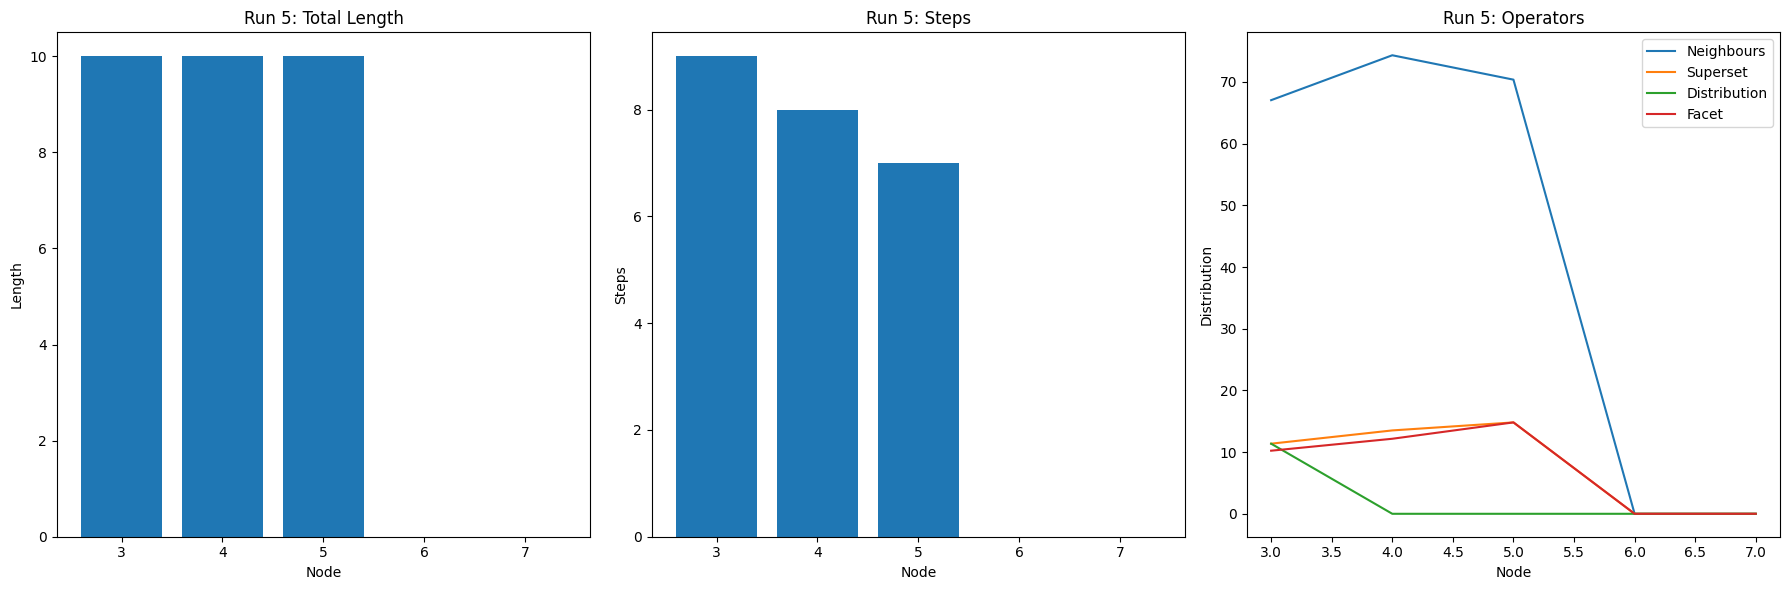

In [53]:
raw_pipelines = [json.loads(doc) for doc in vector_store.documents]
max_k = 3

for run, raw_pipeline in enumerate(raw_pipelines[:2]):
    max_length = max(len(raw_pipeline), 1)  # Ensure there's at least one step
    
    total_length = np.zeros(max_length)
    steps = np.zeros(max_length)
    fam = np.zeros(max_length)
    neighbours = np.zeros(max_length)
    superset = np.zeros(max_length)
    distribution = np.zeros(max_length)
    facets = np.zeros(max_length)
    steps = np.zeros(max_length)
    fam = np.zeros(max_length)

    for k in range(max_k, 0, -1):
        current_step = len(raw_pipeline) - k - 1
        
        partial_pipeline = revert_pipeline(raw_pipeline, k=k)
        partial_embedding = pipeline_to_embedding(partial_pipeline)
        
        neighbouring_results = vector_store.search(embedding=partial_embedding, k=15)
        neighbouring_pipelines = [
            result_to_pipeline(result)
            for result in neighbouring_results
        ]
        neighbouring_payloads = [
            payload_from_search_result(pipeline, current_step)
            for pipeline in neighbouring_pipelines
        ]
        
        if len(neighbouring_payloads) > 0:
            length_of_pipeline = length(neighbouring_payloads)
            total_length[max_k - k] = length_of_pipeline
            steps[max_k - k] = length_of_pipeline - current_step
            fam[max_k - k] = familiarity(neighbouring_payloads)
            neighbours[max_k - k] = one_operator(neighbouring_payloads, 'remaining_operators_by_neighbors')
            superset[max_k - k] = one_operator(neighbouring_payloads,'remaining_operators_by_superset')
            distribution[max_k - k] = one_operator(neighbouring_payloads,'remaining_operators_by_distribution')
            facets[max_k - k] = one_operator(neighbouring_payloads,'remaining_operators_by_facet')
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot total_length
    axs[0].bar(range(3, len(total_length) + 3), total_length)
    axs[0].set_xlabel('Node')
    axs[0].set_ylabel('Length')
    axs[0].set_title(f'Run {run+1}: Total Length')

    # Plot steps
    axs[1].bar(range(3, len(steps) + 3), steps)
    axs[1].set_xlabel('Node')
    axs[1].set_ylabel('Steps')
    axs[1].set_title(f'Run {run+1}: Steps')

    # Plot distributions of operators
    axs[2].plot(range(3, len(neighbours) + 3), neighbours, label='Neighbours')
    axs[2].plot(range(3, len(superset) + 3), superset, label='Superset')
    axs[2].plot(range(3, len(distribution) + 3), distribution, label='Distribution')
    axs[2].plot(range(3, len(facets) + 3), facets, label='Facet')
    axs[2].set_xlabel('Node')
    axs[2].set_ylabel('Distribution')
    axs[2].set_title(f'Run {run+1}: Operators')
    axs[2].legend() 

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()

### Experiment: stability evaluation - evaluating moves towards most probable scenarios

In [38]:
from concurrent.futures import ThreadPoolExecutor

def calculate_coefficient_of_variation(data, param):
    values = [node[param] for node in data]
    mean = np.mean(values)
    std_dev = np.std(values)
    if mean == 0:
        return 0.0  # To handle division by zero
    return std_dev / mean

def attribute_stability_metric(exploration_payloads):
    if not len(exploration_payloads):
        return 0.0
    coefficients_of_variation = {
        param: calculate_coefficient_of_variation(exploration_payloads, param) 
        for param in ['total_length', 'familiarity', 'neighbour_percentage', 'superset_percentage', 'distribution_percentage', 'facet_percentage']
    }
    weights = {
        'total_length': 0.1,
        'familiarity': 0.1,
        'neighbour_percentage': 0.2, 
        'superset_percentage': 0.2,
        'distribution_percentage': 0.2, 
        'facet_percentage': 0.2
    }
    weighted_average = sum(coefficients_of_variation[key] * weights[key] for key in coefficients_of_variation) / sum(weights.values())
    return weighted_average

def exploration_payload(payloads, current_step):
    total_length = length(payloads)

    most_probable_operator_key, _ = dist_operators(payloads, top_k=1)[0]
    most_probable_operator_name = most_probable_operator_key.replace('remaining_operators_', '')
    
    most_probable_dimension_key, _ = dist_dimensions(payloads, top_k=1)[0]
    most_probable_dimension_name = most_probable_dimension_key.replace('remaining_dimensions_', '')

    return {
        "total_length": total_length,
        "nodes_left": total_length - current_step,
        "familiarity": familiarity(payloads),
        "most_probable_operator": most_probable_operator_name,
        "most_probable_dimension": most_probable_dimension_name,
        "neighbour_percentage": one_operator(payloads, 'remaining_operators_by_neighbors'),
        "superset_percentage": one_operator(payloads, 'remaining_operators_by_superset'),
        "distribution_percentage": one_operator(payloads, 'remaining_operators_by_distribution'),
        "facet_percentage": one_operator(payloads, 'remaining_operators_by_facet')
    }

def make_experiment(vector_store, terminal_pipeline, terminal_pipeline_id, exploration_steps: int, exploration_lookup: int):
    print(f"Starting an experiment with exploration_steps='{exploration_steps}'")
    start_time = time()

    exploration_payloads = []
    actual_exploration_lookups = np.array([])
    within_lookups = np.array([])
    lookup_ranks = np.array([])

    partial_pipeline = revert_pipeline(terminal_pipeline, k=exploration_steps)

    for k in range(exploration_steps, 0, -1):
        current_step = len(terminal_pipeline) - k
        
        partial_embedding = pipeline_to_embedding(partial_pipeline)
         
        neighbouring_results = vector_store.search(embedding=partial_embedding, k=exploration_lookup)
        neighbours_pipeline_ids = [
            result_to_id(result)
            for result in neighbouring_results
        ]
        neighbouring_pipelines = [
            result_to_pipeline(result)
            for result in neighbouring_results
        ]
        neighbouring_payloads = [
            payload_from_search_result(pipeline, current_step)
            for pipeline in neighbouring_pipelines
        ]

        exploration = exploration_payload(neighbouring_payloads, current_step)
        exploration_payloads.append(exploration)

        actual_exploration_lookups = np.append(actual_exploration_lookups, len(neighbours_pipeline_ids))
        within_lookups = np.append(within_lookups, terminal_pipeline_id in neighbours_pipeline_ids)
        try:
            lookup_index = neighbours_pipeline_ids.index(terminal_pipeline_id)
            lookup_ranks = np.append(lookup_ranks, int(lookup_index) + 1)
        except:
            pass

        next_partial_node, _ = next_node_from_pipeline(
            partial_pipeline, 
            database_pipeline_cache,
            model_manager,
            operator=exploration['most_probable_operator'],
            dimension=exploration['most_probable_dimension']
        )
        partial_pipeline.append(next_partial_node)
        
    attribute_stability_score = attribute_stability_metric(exploration_payloads)
    actual_exploration_lookup = int(actual_exploration_lookups.mean()) if len(actual_exploration_lookups) > 0 else None
    mean_within_lookup = int(within_lookups.mean()) if len(within_lookups) > 0 else 0.0
    mean_lookup_rank = int(lookup_ranks.mean()) if len(lookup_ranks) > 0 else None

    print(f"Finished an experiment with  exploration_steps='{exploration_steps}', lookup_rank='{mean_lookup_rank}' and exploration_lookup='{exploration_lookup}' in {time() - start_time}s")
    
    return {
        "terminal_pipeline_id": terminal_pipeline_id,
        "attribute_stability_score": attribute_stability_score,
        "actual_exploration_lookup": actual_exploration_lookup,
        "mean_within_lookup": True if mean_within_lookup else False,
        "mean_lookup_rank": mean_lookup_rank
    }

def experiment_metadata(experiment, exploration_steps: int, expected_exploration_lookup: int):
    r = {
        "experiment": experiment + 1,
        "exploration_steps": exploration_steps,
        "expected_exploration_lookup": expected_exploration_lookup
    }
    return r

def run_single_experiment(args):
    try:
        experiment, vector_store, terminal_pipeline, terminal_pipeline_id, explorations_steps, exploration_lookups = args
        results = []
        for exploration_lookup in exploration_lookups:
            for exploration_steps in range(*explorations_steps):
                experiment_config = (exploration_steps, exploration_lookup)
                results.append({
                    **experiment_metadata(
                        experiment,
                        *experiment_config
                    ),
                    **make_experiment(
                        vector_store,
                        terminal_pipeline,
                        terminal_pipeline_id,
                        *experiment_config
                    )
                })
        return results
    except Exception as e:
        print(f"Error in experiment {args[0]}: {e}")  # Log the error and experiment details
        print(traceback.format_exc())
        return []  # Return an empty list or some error indicator

def run_experiments(n: int = 1000, explorations_steps: tuple = (3, 6), exploration_lookups: list = [10, 20, 50, 100], max_workers: int = 1):
    pipeline_sampler = make_document_sampler(vector_store)

    # Prepare arguments for each experiment
    experiments_args = []
    for experiment in range(n):
        sampled_pipeline = None
        while sampled_pipeline is None:
            sampled_pipeline_index, sampled_pipeline_id = pipeline_sampler()
            try:
                sampled_pipeline = result_to_pipeline(vector_store.get(sampled_pipeline_id))
            except Exception as e:
                print(f"Failed to parse Pipeline[id={sampled_pipeline_id}]")
        experiments_args.append((experiment, vector_store, sampled_pipeline, sampled_pipeline_id, explorations_steps, exploration_lookups))
    
    # Run experiments in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(run_single_experiment, experiments_args), total=n))
    
    # Collect all results into a single DataFrame
    experiments = pd.DataFrame([item for sublist in results for item in sublist])
    return experiments

In [39]:
experiments_path = 'data/nle_experiments_1_k-3-5.csv'

if pathlib.Path(experiments_path).exists():
    experiments_df = pd.read_csv(experiments_path)
else:
    experiments_df = run_experiments(
        n=1,
        explorations_steps=(3, 6),
        exploration_lookups=[10, 25, 50, 100, 150, 200]
    )

In [40]:
experiments_df.to_csv(experiments_path, index=False)